# Making figure 3

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange
import seaborn as sns
from utils import get_logs_and_files, convert_train_to_test_idx

In [2]:
# exp_name= 'neurips'
exp_name= 'neurips/policy'
# exp_name= 'neurips/brittle_policy'
# exp_name= 'neurips/bu'
exp_name= 'paper_data/CAI'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)
testing_log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
training_log_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)
print('testing_logs :', testing_log_files)
print('training_logs :', training_log_files)

current folder:  /home/ahummos/code/multiplicative/analysis
testing_logs : ['testing_log_seed2_paradigm_seq_mul_tasks_14_0.0_0.0_0.4_.npy']
training_logs : ['training_log_seed2_paradigm_seq_mul_tasks_14_0.0_0.0_0.4_.npy']


In [6]:
idx = 0
training_file= data_folder+ training_log_files[idx]
testing_file= data_folder+ testing_log_files[idx]
config_file= data_folder+ config_files[idx]
config= np.load( config_file, allow_pickle=True).item()
training_log = np.load( training_file, allow_pickle=True).item()
testing_log = np.load( testing_file, allow_pickle=True).item()
config.no_of_tasks = len(config.tasks)


Bbox(x0=0.125, y0=0.7158695652173913, x1=0.9, y1=0.88)


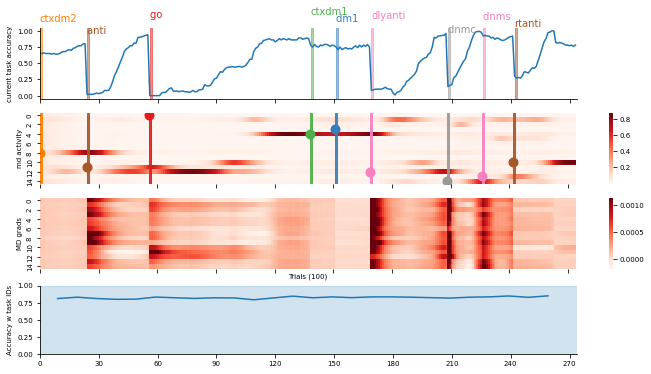

In [7]:
def plot_credit_assignment_inference( config, training_log, testing_log):
    if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    elif len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    else: 
        # len(training_log.md_context_ids) > 0: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]

    mg = np.stack(training_log.md_grads)
    mg = mg.mean(1) #(7957, 15) # average across batch

    x0, x1 = 0, training_log.stamps[-1]
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 

    fig, axes = plt.subplots(4,1, figsize=[12,6], sharex = True)

    ax = axes[0]
    print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))

    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=10)
    ax.set_ylabel('current task accuracy')

    # ax.set_xlim([x0, x1])
    # for ri in range(len(training_log.switch_trialxxbatch)-1):
    #     ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
    ax = axes[1]
    tdci = np.stack(context_ids)
    mtd = tdci.mean(1) # (7729, 15)
    im = sns.heatmap(mtd.T, cmap='Reds',ax = ax)
    ax.set_xlim([x0, x1])
    ax.set_ylabel('md activity')
    # ax.colorbar()
    # plt.colorbar(im) #, ax=ax.ravel().tolist())


    ax.set_xlim([x0, x1])

    # ax.set_ylim([0,1])
    for ri in range(len(switches)-1):
        # print(ri)
        ax.scatter(switches[ri], (training_log.switch_task_id[ri]+0.5), color =cmap.to_rgba(training_log.switch_task_id[ri]) ,  linewidth=4, )#alpha=0.2)
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.9)
    
    ax = axes[2]

    ax = sns.heatmap(mg.T, cmap='Reds', ax = ax, vmax=mg.max()/3)
    # ax.set_xticks(list(range(0, x1, 200)))
    # ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    ax.set_xlim([x0, x1])
    ax.set_ylabel('MD grads')
    ax.set_xlabel('Trials (100)')
    # plt.colorbar(ax)
    
    ax = axes[3]
    t = 0
    d = training_log.stamps[-1]
    average_acc =[]
    taa = []
    for logi in range(config.no_of_tasks):
        taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
    average_acc.append(np.stack(taa))

    testing_t = convert_train_to_test_idx(training_log, testing_log, t)
    testing_e =convert_train_to_test_idx(training_log, testing_log, t+d)
    ax.plot(testing_log.stamps[testing_t:testing_e], average_acc[0].mean(0)[testing_t:testing_e])
    ax.axvspan(0, d, color='tab:blue', alpha=0.2)
    ax.set_ylim([0,1])
    ax.set_ylabel('Accuracy w task IDs')
    ax.set_xticks(list(range(0, x1, 30)))
    ax.set_xticklabels([str(i) for i in list(range(0, x1, 30))])
    # ax.set_title('With task rule input provided')
    # print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.1249], [.747, 0.283]]))    
    # try:
        # plt.savefig('./files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
    # except:
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bu_optimizing_many_batches.jpg', dpi=300)
plot_credit_assignment_inference(config, training_log, testing_log)
# plt.savefig('./files'+f'/CAI_summary_BU.pdf', dpi=300)

### T-SNE

In [5]:
exp_name= 'neurips/bu'
# exp_name= 'paper_data/CAI'
exp_name= 'paper_data/tsne_run'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)

current folder:  /home/ahummos/code/multiplicative/analysis


In [6]:
training_file= data_folder+ 'training_log_seed2_paradigm_seq_mul_tasks_14_3.0_0.0_0.4_.npy'
testing_file= data_folder+ 'testing_log_seed2_paradigm_seq_mul_tasks_14_3.0_0.0_0.4_.npy'
config_file= data_folder+ 'config_seed2_paradigm_seq_mul_tasks_14_3.0_0.0_0.4_.npy'
config= np.load( config_file, allow_pickle=True).item()
training_log = np.load( training_file, allow_pickle=True).item()
testing_log = np.load( testing_file, allow_pickle=True).item()

In [7]:
solved_idx=(np.array(training_log.trials_to_crit[1:]) !=99) # tasks that wehere actually solved
print(f'solved tasks ratio {np.sum(solved_idx)/solved_idx.size:2.1f}')

solved tasks ratio 0.5


In [8]:
end_block_indexes = np.array(training_log.switch_trialxxbatch[1:]) -1 # indexes for the last trial in each block, right before reaching crit. ignore the first switch recorded at 0.
end_block_indexes = end_block_indexes[solved_idx]
# print(end_block_indexes)
bid = np.stack(training_log.bu_context_ids)  # (275, 100, 15)
bidm = bid.mean(1) #average out batch dim
end_block_bidm = bidm[end_block_indexes]
end_block_ids = np.array(training_log.task_ids)[end_block_indexes]
# len(training_log.task_ids) # 275

using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/336 [00:00<?, ?it/s]

fitting...


  0%|          | 0/4000 [00:00<?, ?it/s]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


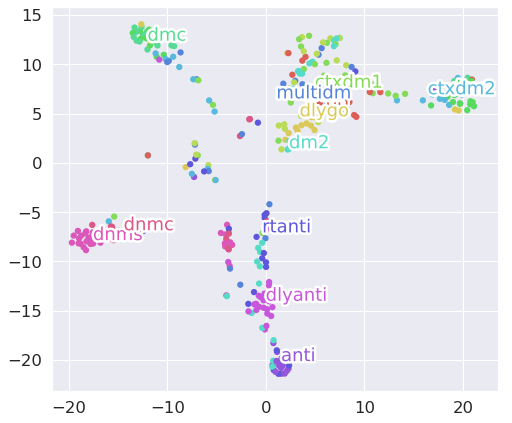

In [38]:
import matplotlib.patheffects as PathEffects
%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


from tsne_torch import TorchTSNE as TSNE

sampling_rate = 200
X = end_block_bidm  # shape (n_samples, d)
colors = end_block_ids
X_emb = TSNE(n_components=2, perplexity=30, n_iter=4000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)
x= X_emb 

num_classes = X.shape[1]
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])

# add the labels for each digit corresponding to the label
txts = []


for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config.human_task_names[i], color = palette[i], fontsize=18)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)
# plt.savefig('./files/pdfs/CAI_tsne.pdf', dpi=300)

## Figure pretrained network adaptation

In [9]:
# exp_name= 'neurips'
# exp_name= 'neurips/policy'
# exp_name= 'neurips/brittle_policy'
# exp_name= 'neurips/bu'
exp_name= 'paper_data/policy'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)
testing_log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
training_log_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)
print('testing_logs :', testing_log_files)
print('training_logs :', training_log_files)

current folder:  /home/ahummos/code/multiplicative/analysis
testing_logs : ['testing_log_seed0_paradigm_seq_mul_tasks_14_1.0_0.0_0.4_.npy']
training_logs : ['training_log_seed0_paradigm_seq_mul_tasks_14_1.0_0.0_0.4_.npy']


In [10]:
idx = 0
training_file= data_folder+ training_log_files[idx]
testing_file= data_folder+ testing_log_files[idx]
config_file= data_folder+ config_files[idx]
config= np.load( config_file, allow_pickle=True).item()
training_log = np.load( training_file, allow_pickle=True).item()
testing_log = np.load( testing_file, allow_pickle=True).item()


Bbox(x0=0.125, y0=0.7158695652173913, x1=0.9, y1=0.88)


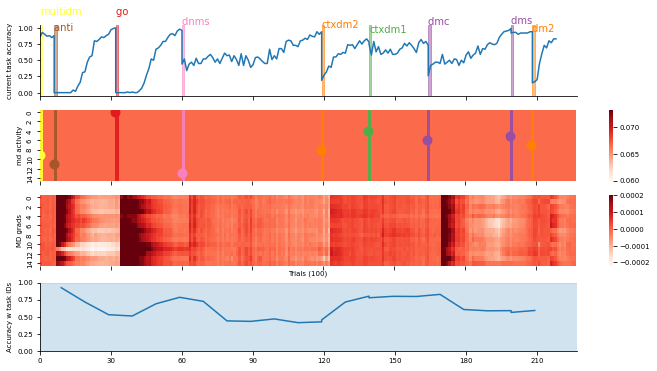

In [11]:
plot_credit_assignment_inference(config, training_log, testing_log)